In [1]:
import sys
lib = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy\utilities\droplet_dataset'
lib2 = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy\utilities'
lib3 = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy\data_analysis'
lib4 = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy'
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)

In [2]:
import os
from os.path import join
import sklearn
# from droplet_dataset import *
# from utilities import *
from matplotlib import pyplot
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
from scipy.stats import pearsonr
from matplotlib.pyplot import figure
import time
import matplotlib.pyplot as plt
import copy
from sklearn.cluster import KMeans
from collections import Counter
from PIL import Image, ImageColor
from termcolor import colored
from sklearn.manifold import TSNE
from DL.Mars_seq_DL.data_loading import extract_droplet_data_from_pickle


* All Functions needed

In [3]:
def draw(chro_genes_vals):
    n_gene = chro_genes_vals.shape[0]
    n_cells = chro_genes_vals.shape[1]
    
    deletions = copy.deepcopy(chro_genes_vals)
    deletions[deletions < -0.02] = 195
    insertions = copy.deepcopy(chro_genes_vals)
    insertions[insertions > 0.02] = 195


    rgbArray = np.zeros((n_gene, n_cells, 3), 'uint8')
    rgbArray[..., 0] = insertions #*256
    rgbArray[..., 1] = 0 #chro_genes_vals*256
    rgbArray[..., 2] = deletions #chro_genes_vals*256
    img = Image.fromarray(rgbArray)
    return img


def draw_split(_chro_genes_vals, split_idx):
    n_gene = _chro_genes_vals.shape[0]
    n_cells = _chro_genes_vals.shape[1]
    
    deletions = copy.deepcopy(_chro_genes_vals)
    deletions[deletions < -0.02] = 195
    insertions = copy.deepcopy(_chro_genes_vals)
    insertions[insertions > 0.02] = 195


    rgbArray = np.zeros((n_gene, n_cells + 7, 3), 'uint8')
    rgbArray[:, :split_idx+1, 0] = insertions[:, :split_idx+1]
    rgbArray[:, split_idx+8:, 0] = insertions[:, split_idx+1:]
    rgbArray[:, split_idx+1: split_idx+8, 1] = 200
    rgbArray[:, :split_idx+1, 2] = deletions[:, :split_idx+1]
    rgbArray[:, split_idx+8:, 2] = deletions[:, split_idx+1:]
    img = Image.fromarray(rgbArray)
    return img

def draw_split_fragments(_chro_genes_vals, fragments):
    n_gene = _chro_genes_vals.shape[0]
    n_cells = _chro_genes_vals.shape[1]
    
    deletions = copy.deepcopy(_chro_genes_vals)
    deletions[deletions < -0.02] = 195
    insertions = copy.deepcopy(_chro_genes_vals)
    insertions[insertions > 0.02] = 195

#     print(f'length ------ {n_cells + (len(fragments)-1)*6}')
    rgbArray = np.zeros((n_gene, n_cells + (len(fragments)-1)*6, 3), 'uint8')
    for frg_idx, fragment in enumerate(fragments):
        left_idx = fragment[0]
        right_idx = fragment[1]
#         print('\n\n' + str(frg_idx))
#         print(left_idx + (6 * frg_idx))
#         print(right_idx + (6 * frg_idx))
        rgbArray[:, left_idx + (6 * frg_idx): right_idx + (6 * frg_idx), 0] = insertions[:, left_idx: right_idx]
        if frg_idx < len(fragments)-1:
            rgbArray[:, right_idx + (6 * frg_idx): right_idx + (6 * frg_idx)+7, 1] = 200
        rgbArray[:, left_idx + (6 * frg_idx): right_idx + (6 * frg_idx), 2] = deletions[:, left_idx: right_idx]

    img = Image.fromarray(rgbArray)
    return img



def ones_conversion(chro_genes_vals):
    conv = copy.deepcopy(chro_genes_vals)
    conv[conv > 0.02] = 1
    conv[conv < -0.02] = -1
    conv[(conv < 1) & (conv > -1)] = 0
    return conv

def pos_conversion(chro_genes_vals):
    conv = copy.deepcopy(chro_genes_vals)
    conv[conv > 0.02] = 1
    conv[conv < 0.02] = 0
    return conv

def neg_conversion(chro_genes_vals):
    conv = copy.deepcopy(chro_genes_vals)
    conv[conv > -0.02] = 0
    conv[conv < -0.02] = 1
    return conv


def print_list(lst):
    for idx, v in enumerate(lst):
        vv = dict(v)
#         print(f'Fragment {idx+1}. {vv} {round(vv.get(True, 0)/(vv.get(True, 0)+vv.get(False, 0))*100, 2)}')
        print(f'Fragment %2d. %22s%4d' % (idx+1, vv, round(vv.get(True, 0)/(vv.get(True, 0)+vv.get(False, 0))*100, 2))+'%')
    print()


def is_a_cnv_group(cluster):
    cluster = np.abs(ones_conversion(cluster))
    num_of_genes = cluster.shape[1]
    num_of_cells = cluster.shape[0]
#     print(f'gene len {num_of_genes}')
#     print(f'cells len {num_of_cells}')
    
    
#     print(cells_thrshold)
#     print(np.sum(cluster, axis=0).shape)
    cells_thrshold = int(num_of_cells*0.9)
    number_of_cnv_genes_overlap_with_90p_cells = sum(np.sum(cluster, axis=0)>cells_thrshold)
    print(f'Number of CNV genes (approved by > 90% of the cells): {number_of_cnv_genes_overlap_with_90p_cells}')
    
    cells_thrshold = int(num_of_cells*0.8)
    number_of_cnv_genes_overlap_with_80p_cells = sum(np.sum(cluster, axis=0)>cells_thrshold)
    print(f'Number of CNV genes (approved by > 80% of the cells): {number_of_cnv_genes_overlap_with_80p_cells}')

## Selsect the sample and path of the InferCNV output you are interested in

In [4]:
SAMPLE = 'M109'
# All PKL samples path
SAMPLE_PATH = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\scrublet\17.2.21'

OUTPUT_IMMUNE_PATH = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\analysis_conclusions\immune_clustering'
path = join(r'D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\executions\all_data_31.12.20', SAMPLE)
tumor_file = r'infercnv.observations.txt' # tumor cells
reference_file = r'infercnv.references.txt' # immune cells
genome_path = r'D:\Technion studies\Keren Laboratory\Data\inferCNV_data\gencode_v19_gene_pos.txt'
print(f"FILE PATH:\n{join(path, tumor_file)}", end='\n\n')
print(f"SAMPLE: \n{SAMPLE}")

FILE PATH:
D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\executions\all_data_31.12.20\M109\infercnv.observations.txt

SAMPLE: 
M109


## Loading sample CNV map of tumor cells

In [5]:
print(f'LOADING TUMOR FILE:\n{join(path, tumor_file)}', end ='\n\n')

count = 0
genes_vals =[]
gene_names = []
barcodes = None
s_time = time.time()
with open(join(path, tumor_file), 'r') as f:
    for line in f:
        if not count % 1000:
            current_time = time.time() - s_time
            print(f'line num: {count + 1} current time {round(current_time, 2)} sec')
        if count == 0:
            barcodes_length = len(line[:-1].split(' '))
            print(f'number of barcodes {barcodes_length}')
            barcodes = [ii.replace('\"', '') for ii in line.split(' ')]
            barcodes[-1] = barcodes[-1][:-1]
        else:
            gene = [aa for aa in line[:-1].split(' ')]
            gene_names.append(gene[0].replace('\"', ''))
            genes_vals.append([float(val) for val in gene[1:]])
#         if count > 100:
#             break
        count +=1

genes_vals = np.array(genes_vals)
print(f'DONE', end='\n\n')


print(f'Number of genes {count}')
print(f'Number of barcodes {barcodes_length}')

LOADING TUMOR FILE:
D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\executions\all_data_31.12.20\M109\infercnv.observations.txt

line num: 1 current time 0.0 sec
number of barcodes 5711
line num: 1001 current time 2.26 sec
line num: 2001 current time 4.39 sec
line num: 3001 current time 6.53 sec
line num: 4001 current time 8.66 sec
line num: 5001 current time 10.74 sec
DONE

Number of genes 5469
Number of barcodes 5711


## Loading genome file in order to map genes to chromosomes
you must run it in order to investigate IMMUNE AND TUMOR CNVS!

In [6]:
print(f'Loading genome file')


genes_details = list()
with open(genome_path, 'r') as f:
    for line in f:
        genes_details.append(line[:-1].split('\t'))
genome_genes = [gg[0] for gg in genes_details]
gene_names_chr = [(gg, int(genes_details[genome_genes.index(gg)][1].replace('chr', ''))) for gg in gene_names]
chromosomes = list(set([gg[1] for gg in gene_names_chr]))
print(f'DONE')



def retrieve_genes_indices_by_chro(chro_num):
    return [idx for idx, gg in enumerate(gene_names_chr) if gg[1]==chro_num]


Loading genome file
DONE


# Explore sample's properties of interesting cells (tumor)

* Draw all chromosome

In [7]:
print(f"Sample {SAMPLE} details:")
print(f'Number of genes {count}')
print(f'Number of barcodes {barcodes_length}')

Sample M109 details:
Number of genes 5469
Number of barcodes 5711


* Choose fragments to cut the cells in discriminated locations:

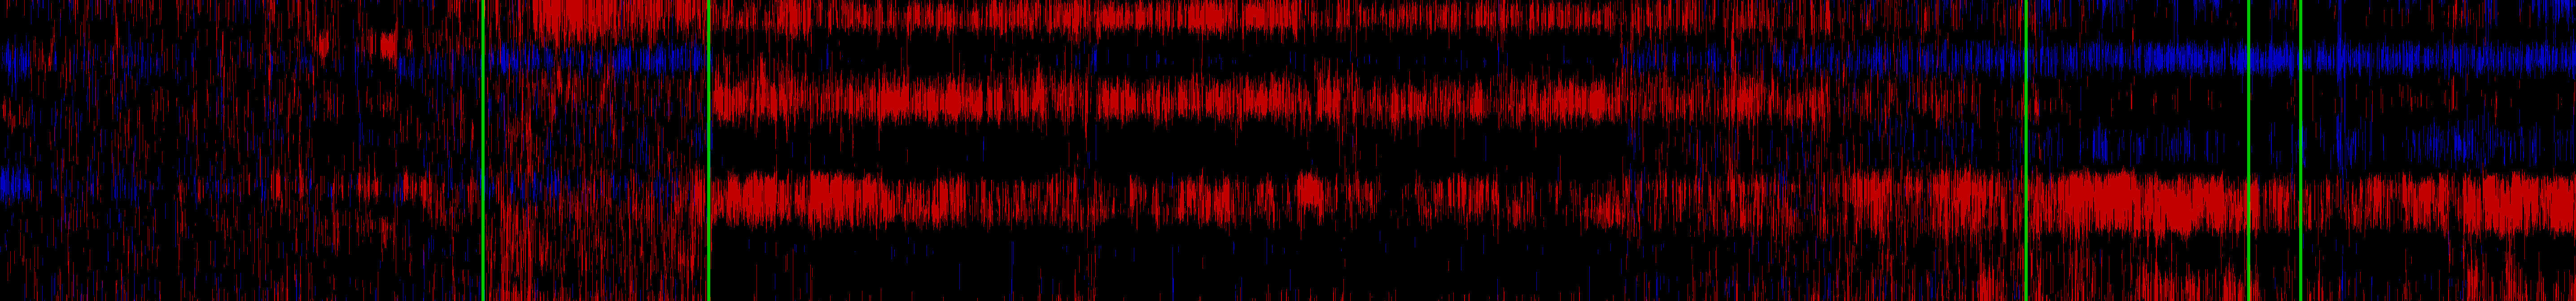

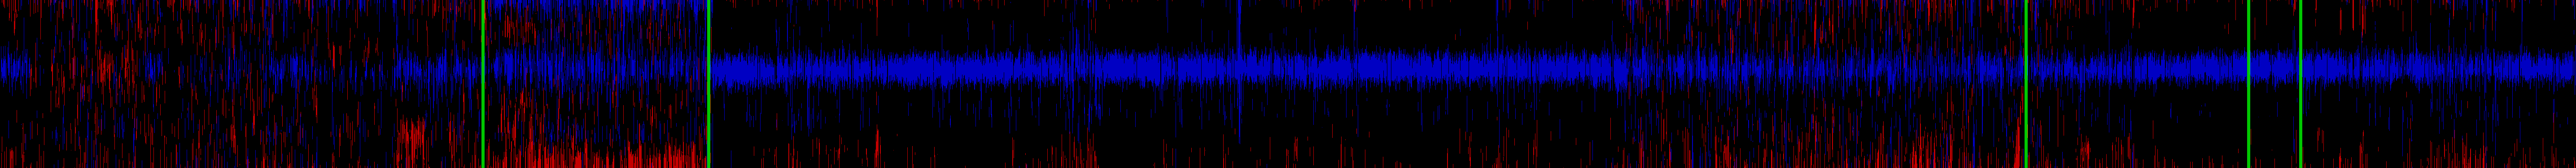

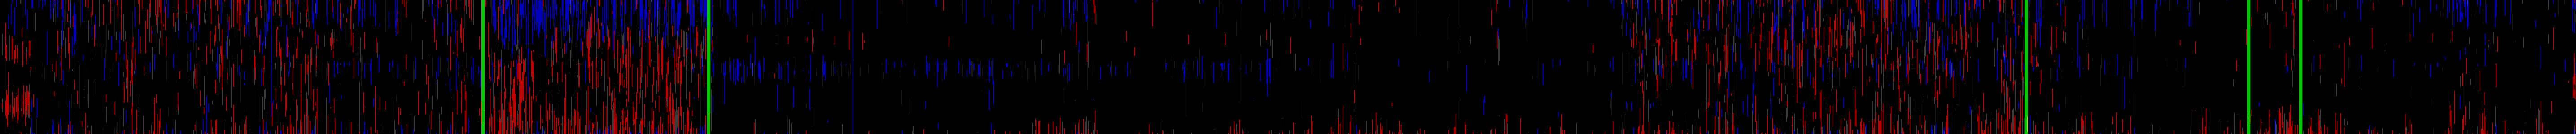

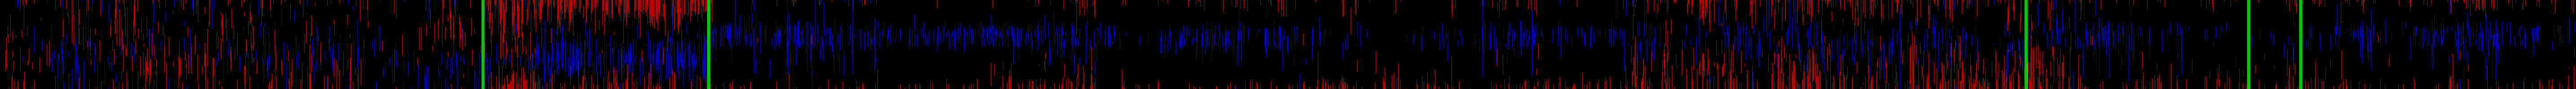

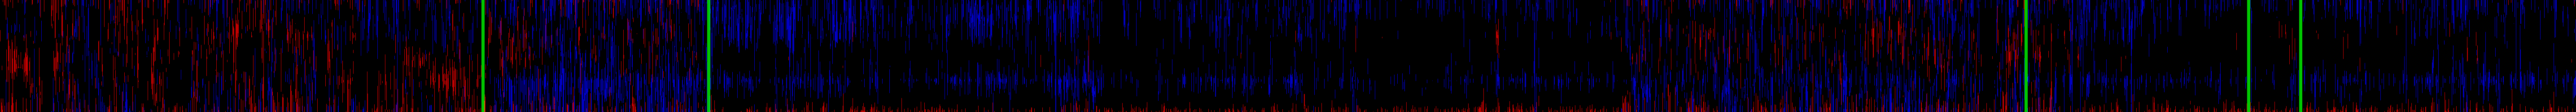

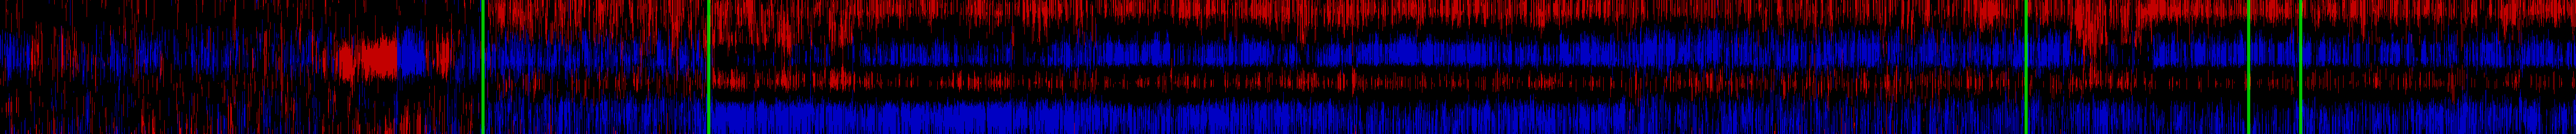

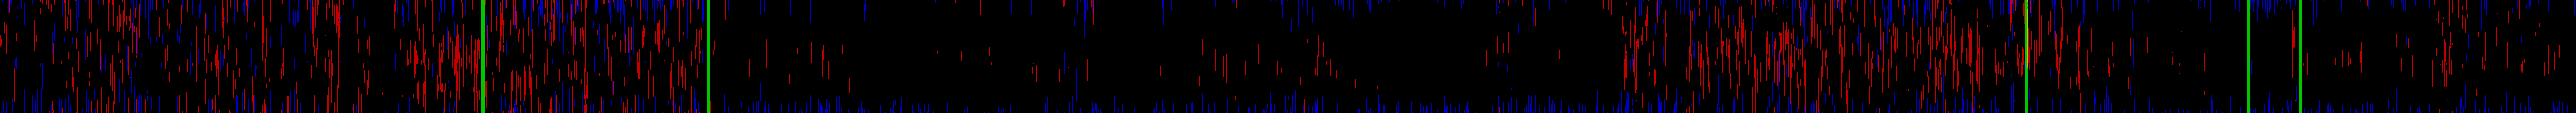

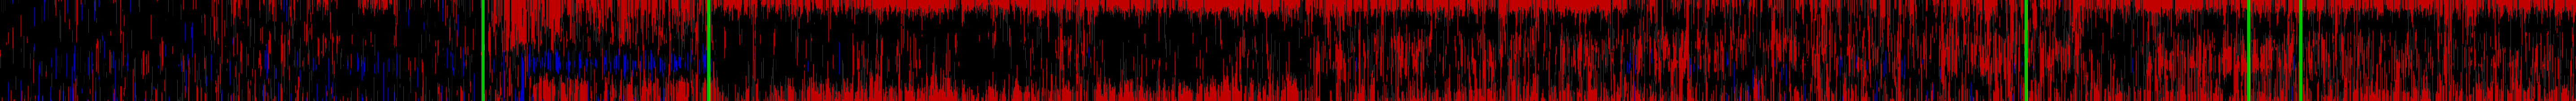

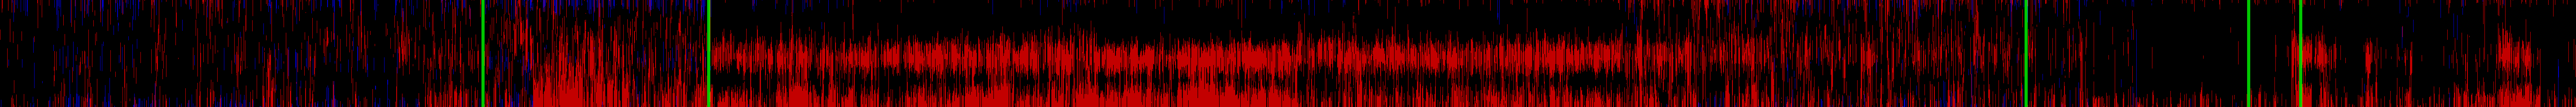

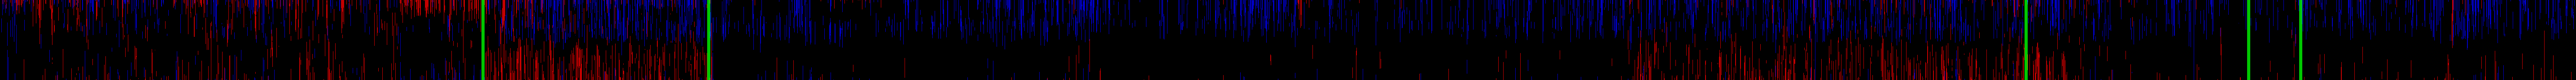

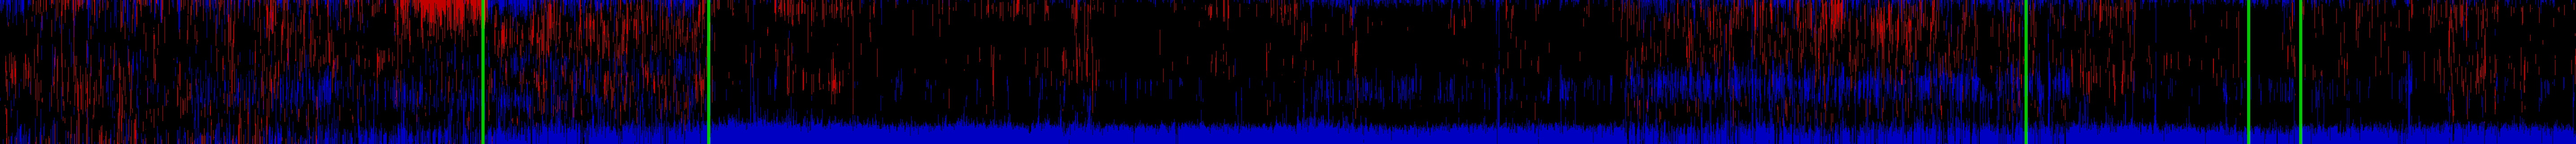

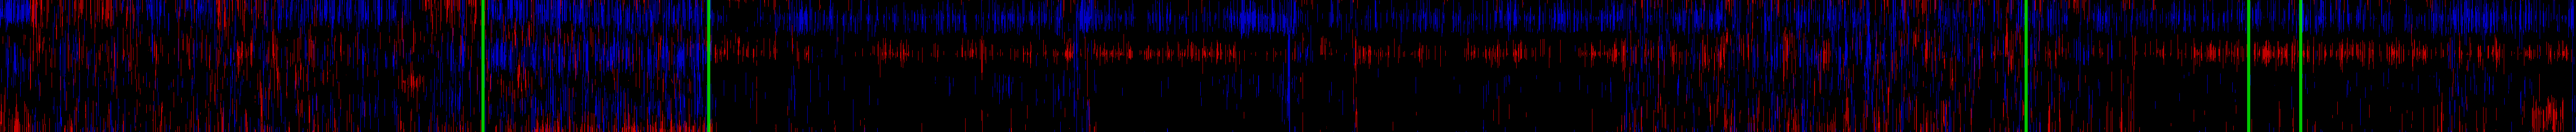

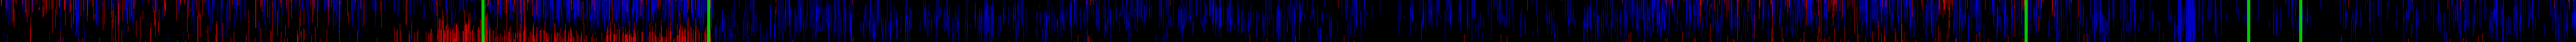

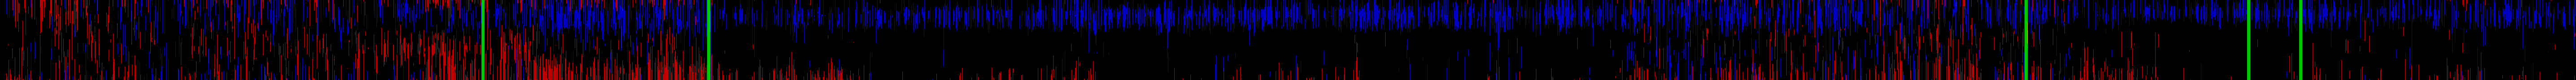

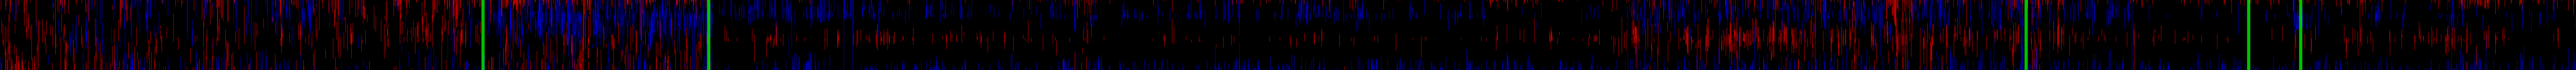

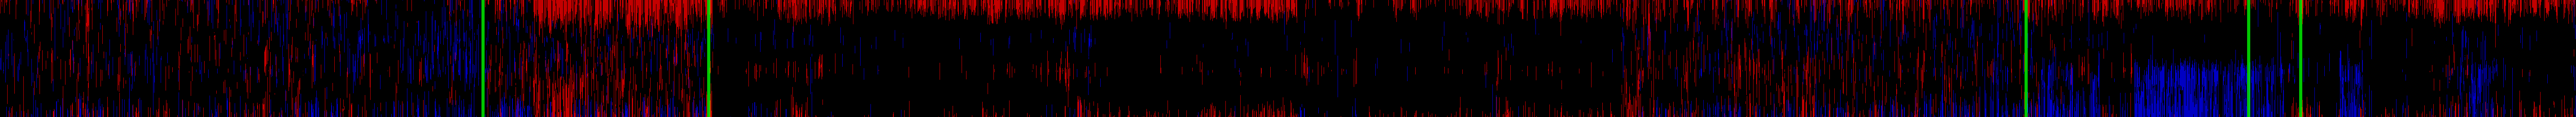

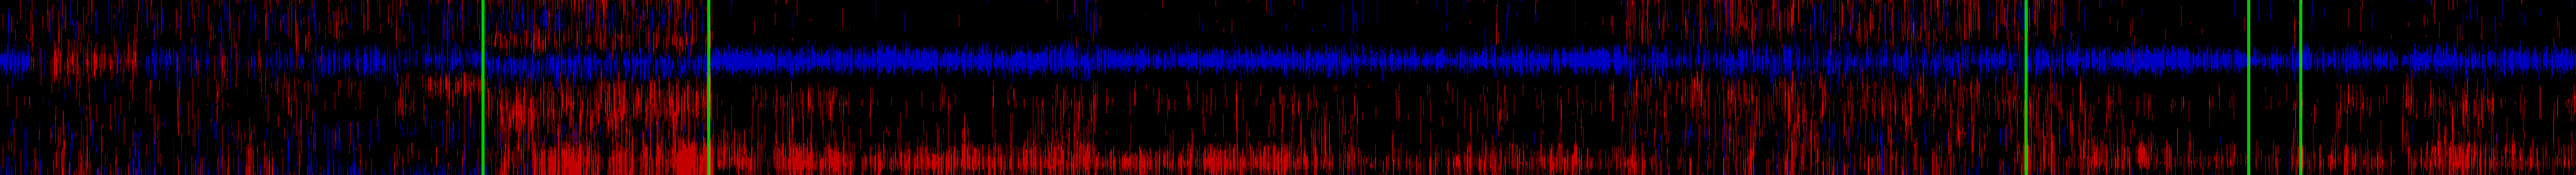

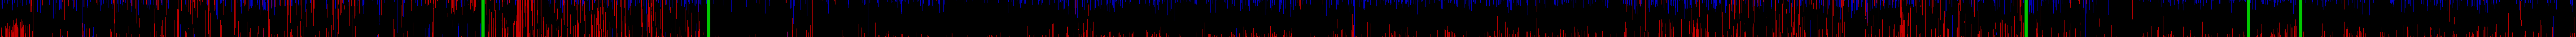

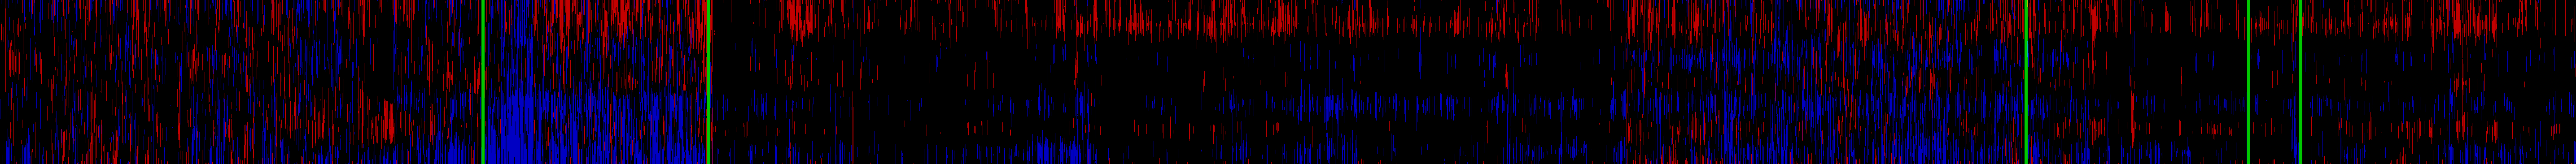

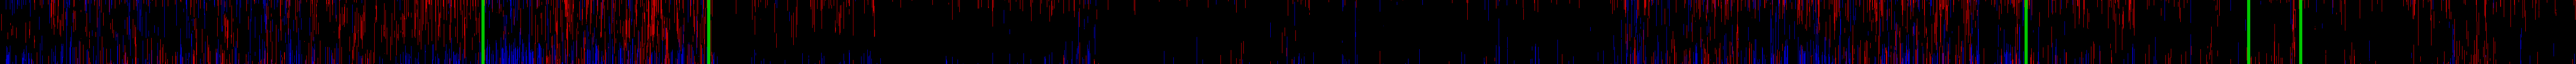

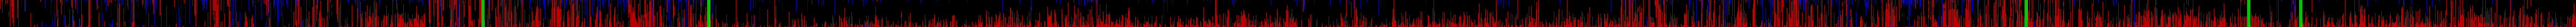

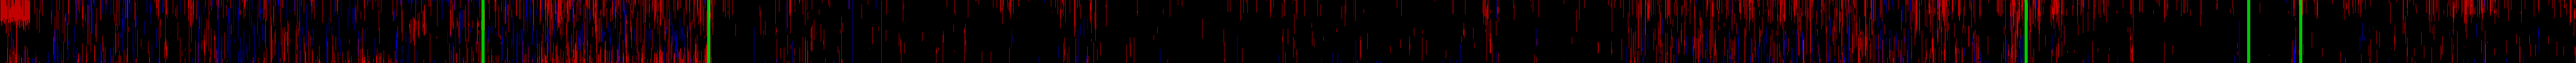

In [9]:
fragments = [(0, 1073), (1073, 1570), (1570, 4500), (4500, 4990), (4990, 5100), (5100, 5711)]
remove_block = False

if not remove_block:
    for _chro_idx in range(1, 23):
        _chro_indices = retrieve_genes_indices_by_chro(_chro_idx)
        _chro_genes_vals = genes_vals[_chro_indices, :]#.sum(axis=0)
        _chro_genes_vals = (_chro_genes_vals-1)


        display(draw_split_fragments(_chro_genes_vals, fragments))

Loading PKL sample to present in 2-dim the original values, marking the fragments that were selected.

In [280]:
sample = extract_droplet_data_from_pickle(join(SAMPLE_PATH, SAMPLE, f'{SAMPLE}.pkl'))

subsets = [sample.get_subset_by_barcodes(barcodes[fragment[0]: fragment[1]]) for fragment in fragments]
cells = sample.get_subset_by_barcodes(barcodes)

* See the properties of the fragments that were selected:

In [281]:
properties = {'doublet': [], 'cancer': [], 'C&I conflict': [], 
              'dying cells': [], 'cancer & dying cells': [], 'C&I conflict & dying cells': []}

for sset in subsets:
    properties['doublet'].append(Counter(sset.cells_information.getattr('is_doublet')))
    properties['cancer'].append(Counter(sset.cells_information.getattr('is_cancer')))
    properties['C&I conflict'].append(Counter(sset.cells_information.getattr('cancer_immune_conflict')))
    properties['dying cells'].append(Counter(sset.cells_information.getattr('is_apoptosis')))
    
    # check cancer and dying
    l1= sset.cells_information.getattr('is_cancer')
    l2 = sset.cells_information.getattr('is_apoptosis')
    l3 = sset.cells_information.getattr('cancer_immune_conflict')
    properties['cancer & dying cells'].append(Counter([l1[i] and l2[i] for i in range(len(l1))]))
    properties['C&I conflict & dying cells'].append(Counter([l2[i] and l3[i] for i in range(len(l3))]))
    
print(colored(f' - Doublet - ', 'red'))
print_list(properties['doublet'])
print(colored(f' - Cancer cells- ', 'red'))
print_list(properties['cancer'])
print(colored(f' - Cancer & Immune conflict - ', 'red'))
print_list(properties['C&I conflict'])
print(colored(f' - Dying cells - ', 'red'))
print_list(properties['dying cells'])
print(colored(f' - Cancer & Dying cells - ', 'red'))
print_list(properties['cancer & dying cells'])
print(colored(f' - Conflict & Dying cells - ', 'red'))
print_list(properties['C&I conflict & dying cells'])

 - Doublet - 
Fragment  1.  {False: 358, True: 2}   0%
Fragment  2.            {False: 85}   0%
Fragment  3.           {False: 135}   0%
Fragment  4.  {False: 177, True: 3}   1%
Fragment  5.           {False: 252}   0%
Fragment  6.  {False: 740, True: 8}   1%
Fragment  7. {False: 1225, True: 9}   0%

 - Cancer cells- 
Fragment  1.  {False: 352, True: 8}   2%
Fragment  2.  {False: 29, True: 56}  65%
Fragment  3. {False: 120, True: 15}  11%
Fragment  4.  {True: 86, False: 94}  47%
Fragment  5. {False: 96, True: 156}  61%
Fragment  6. {True: 598, False: 150}  79%
Fragment  7. {True: 933, False: 301}  75%

 - Cancer & Immune conflict - 
Fragment  1. {False: 85, True: 275}  76%
Fragment  2.   {False: 80, True: 5}   5%
Fragment  3.           {False: 135}   0%
Fragment  4. {False: 144, True: 36}  20%
Fragment  5. {True: 48, False: 204}  19%
Fragment  6. {False: 671, True: 77}  10%
Fragment  7. {False: 1034, True: 200}  16%

 - Dying cells - 
Fragment  1.  {False: 359, True: 1}   0%
Fragment  

* Find 2-dim representation with TSNE

(2994, 21462)
670


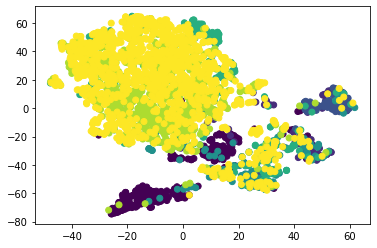

In [293]:
print(cells.counts.shape)
filterd_variance_cells = cells.filter_genes_by_variance(6, in_place=False)
cells_embedded = TSNE(n_components=2, random_state=0).fit_transform(filterd_variance_cells.counts)
print(filterd_variance_cells.number_of_genes)
cells_embedded.shape

colors = np.zeros(len(cells_embedded))
for idx, frg in enumerate(fragments):
    lf = frg[0]
    ri = frg[1]
    colors[lf:ri] = int(idx * (10/len(fragments)))

plt.scatter(cells_embedded[:,0], cells_embedded[:,1], c=colors)

# Examining immune cells with CNVs
#### Those CNVs are similar to tumor CNVs and therefore suspected to be doublets.
* we will set the scope of the interesting cells and then we check if the are taged as dying cells (apoptosis) and if they are clusterd together.


In [933]:
print(f"Current sample {SAMPLE}")

Current sample M137


* Loading sample CNV map of immune cells

In [934]:
print(f'LOADING REFERENECE FILE:\n{join(path, reference_file)}', end ='\n\n')

count = 0
reference_genes_vals =[]
reference_gene_names = []
reference_barcodes = None
s_time = time.time()
with open(join(path, reference_file), 'r') as f:
    for line in f:
        if not count % 1000:
            current_time = time.time() - s_time
            print(f'line num: {count + 1} current time {round(current_time, 2)} sec')
        if count == 0:
            barcodes_length = len(line[:-1].split(' '))
            print(f'number of barcodes {barcodes_length}')
            reference_barcodes = [ii.replace('\"', '') for ii in line.split(' ')]
            reference_barcodes[-1] = reference_barcodes[-1][:-1]
        else:
            gene = [aa for aa in line[:-1].split(' ')]
            reference_gene_names.append(gene[0].replace('\"', ''))
            reference_genes_vals.append([float(val) for val in gene[1:]])
#         if count > 100:
#             break
        count +=1

reference_genes_vals = np.array(reference_genes_vals)
print(f'DONE', end='\n\n')

print(f'Immune cells of sample {SAMPLE}')
print(f'Number of genes {count}')
print(f'Number of barcodes {barcodes_length}')

LOADING REFERENECE FILE:
D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\executions\all_data_31.12.20\M137\infercnv.references.txt

line num: 1 current time 0.05 sec
number of barcodes 3758
line num: 1001 current time 1.76 sec
line num: 2001 current time 3.54 sec
line num: 3001 current time 5.24 sec
line num: 4001 current time 7.02 sec
DONE

Immune cells of sample M137
Number of genes 4128
Number of barcodes 3758


* Choose fragments to cut the cells in discriminated locations:

chro 1


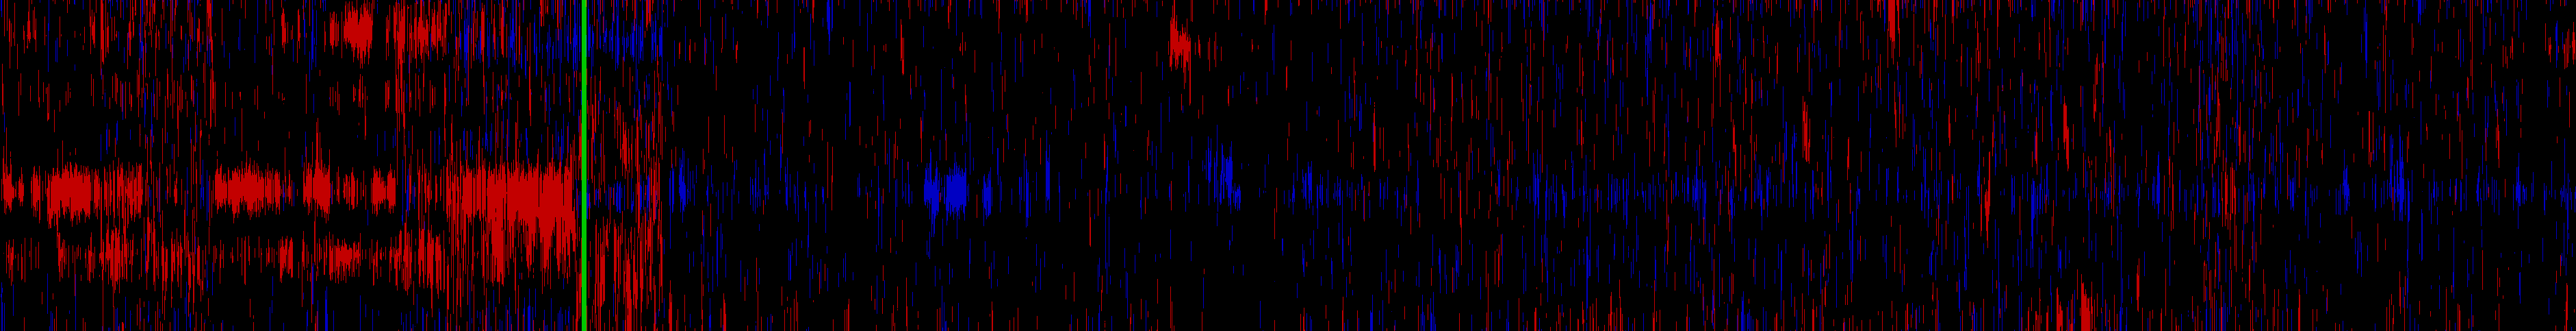

chro 2


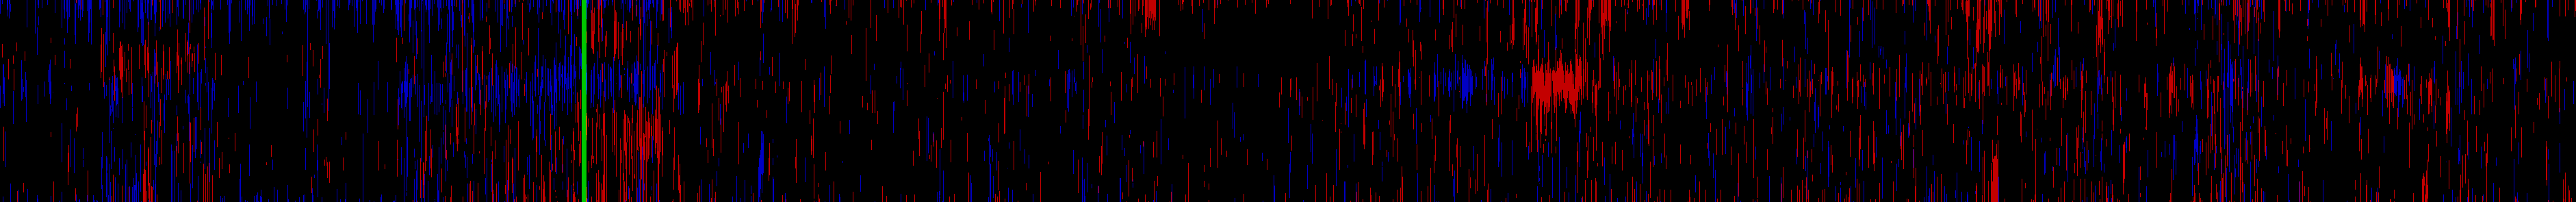

chro 3


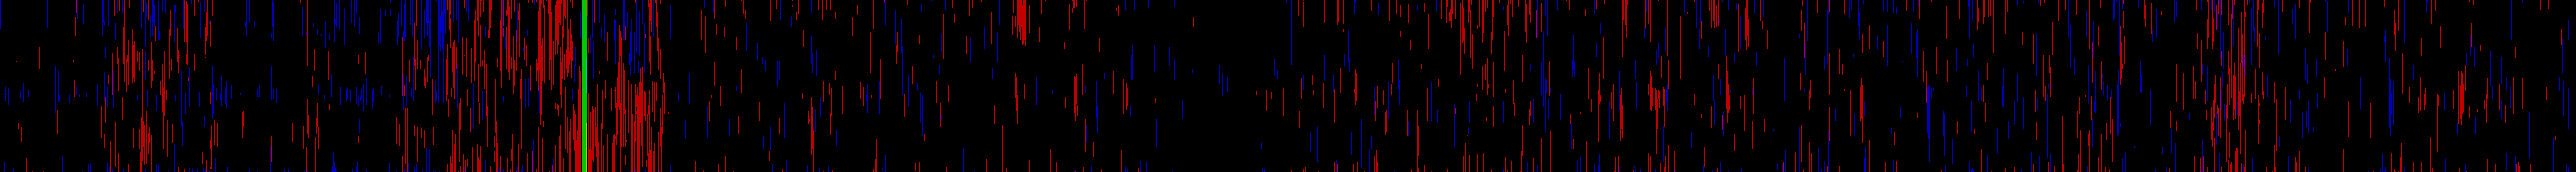

chro 4


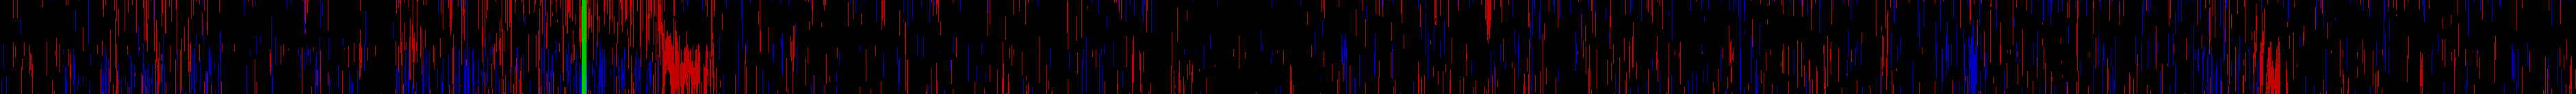

chro 5


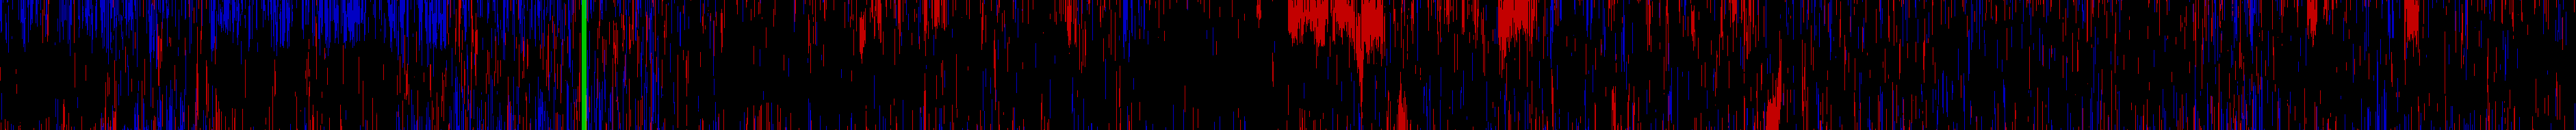

chro 6


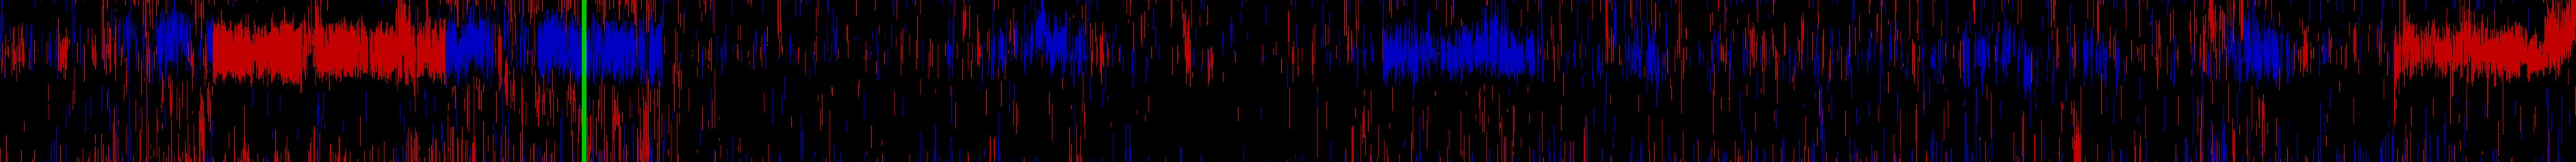

chro 7


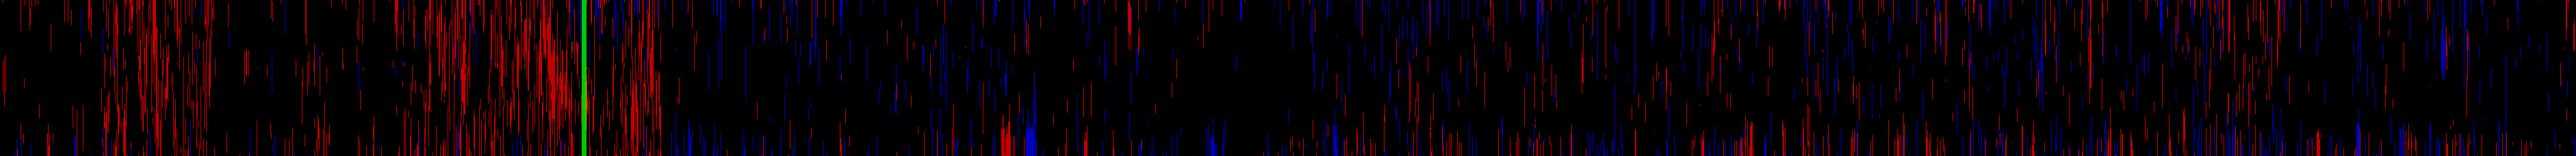

chro 8


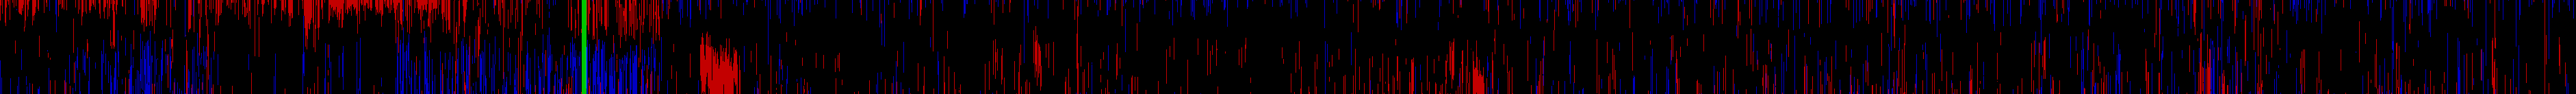

chro 9


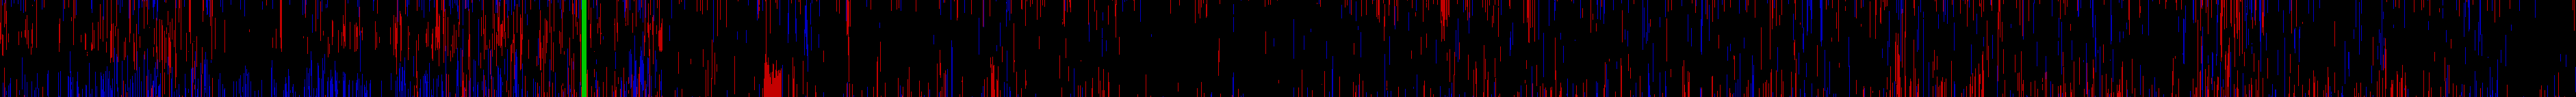

chro 10


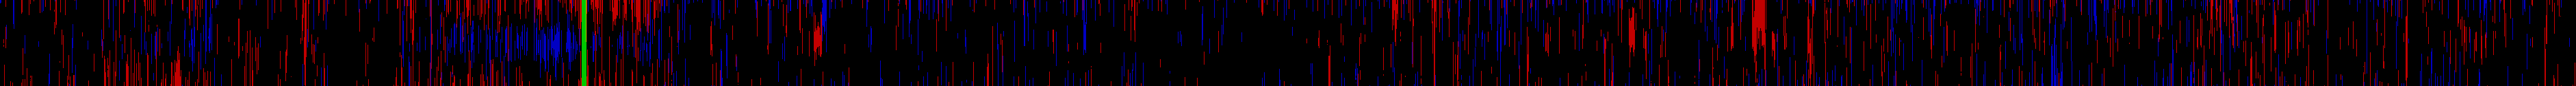

chro 11


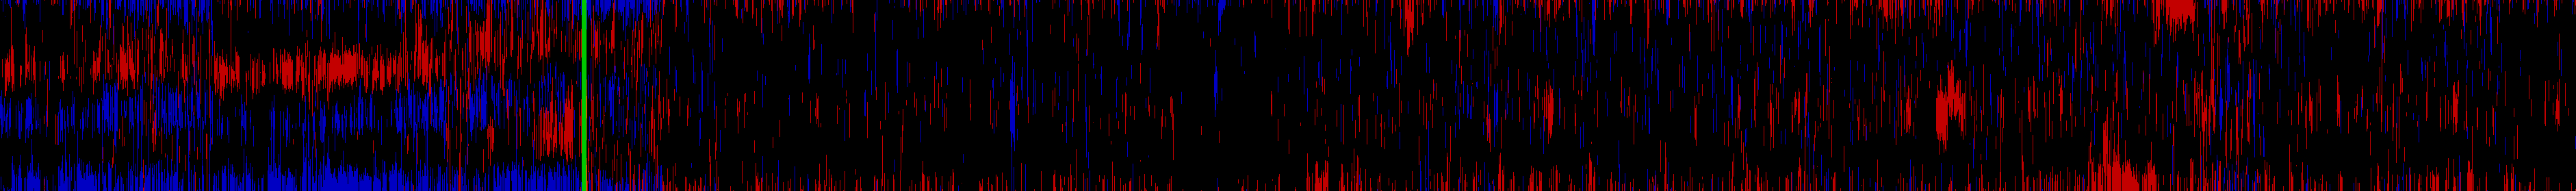

chro 12


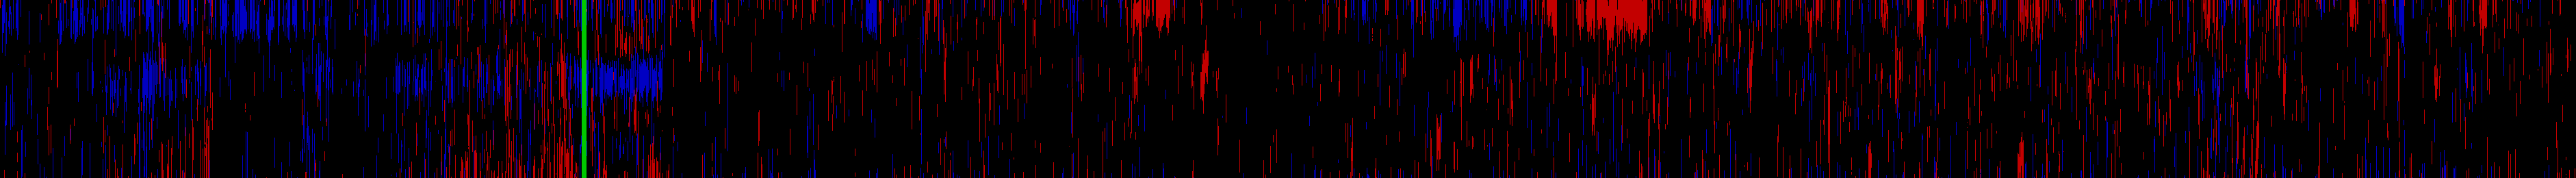

chro 13


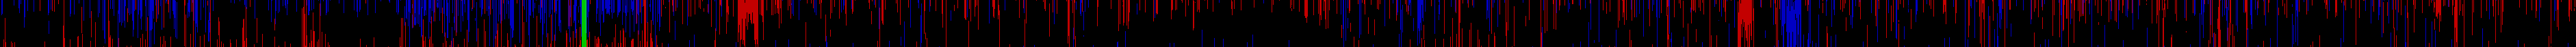

chro 14


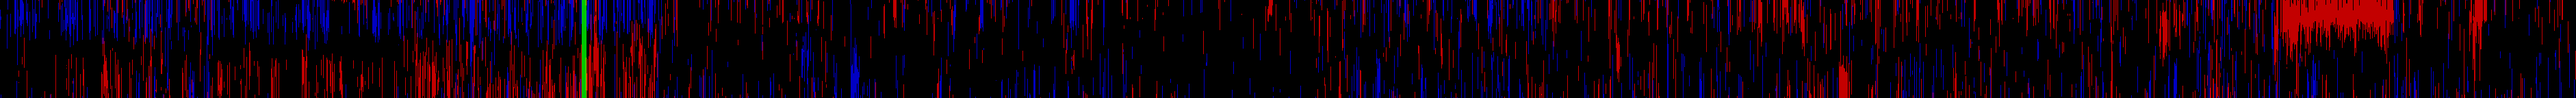

chro 15


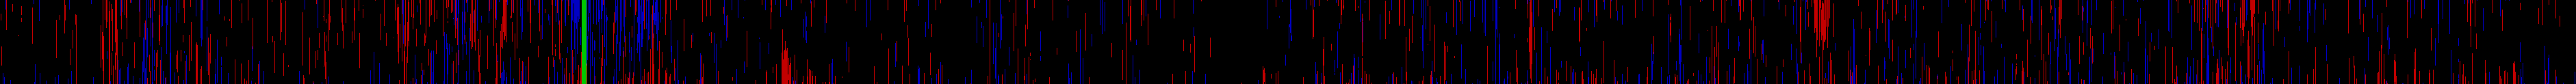

chro 16


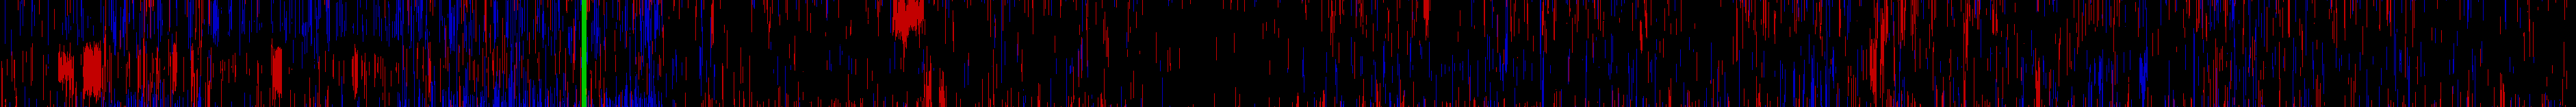

chro 17


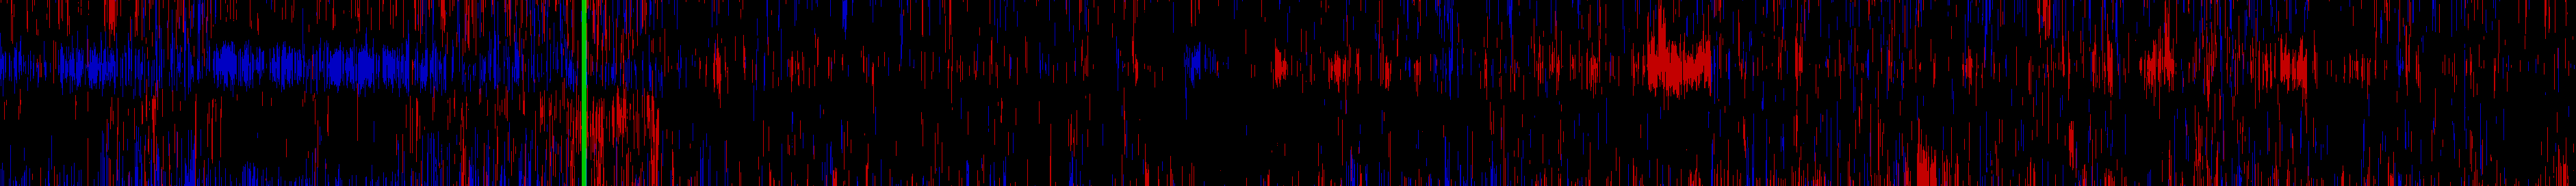

chro 18


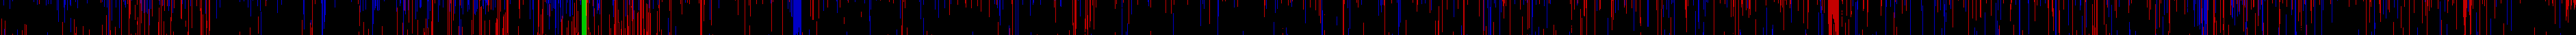

chro 19


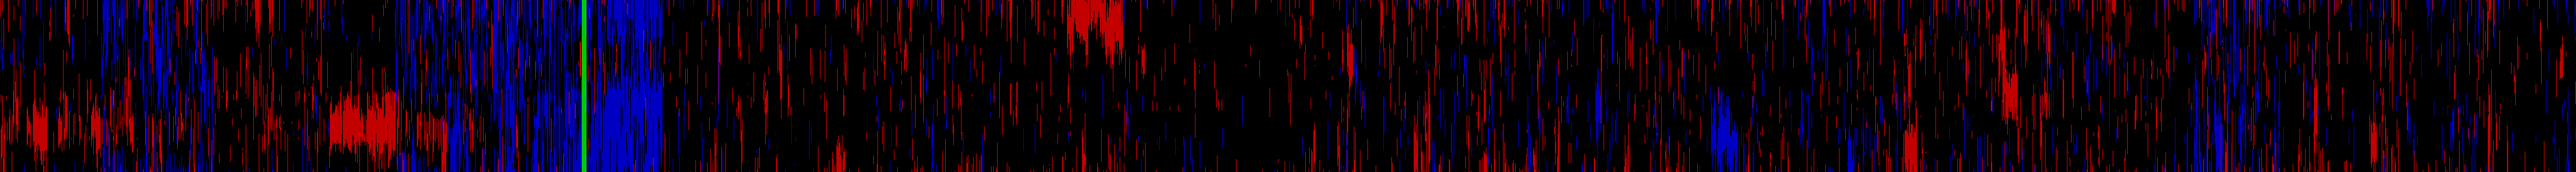

chro 20


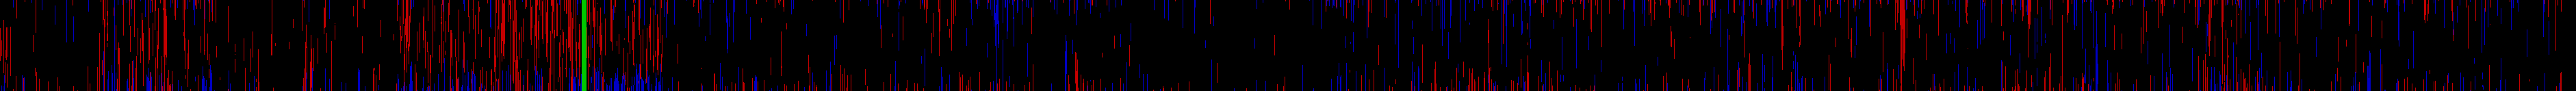

chro 21


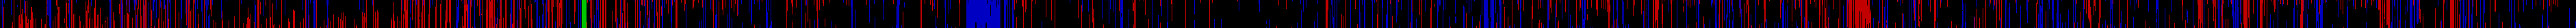

chro 22


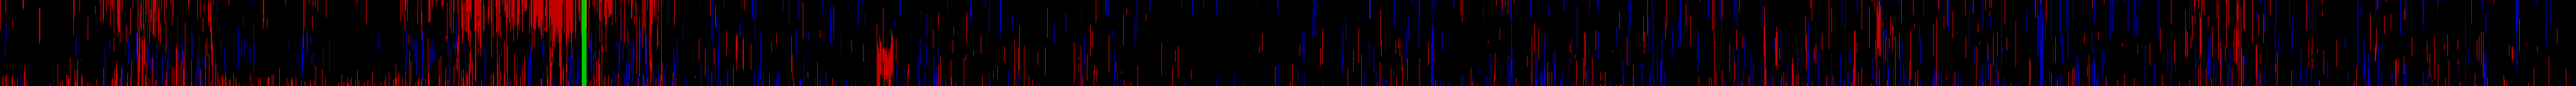

In [945]:
fragments = [(0, 850), (850, 3758)]
remove_block = False # for smaller notebook page, when that code not in use. 

if not remove_block:
    for _chro_idx in range(1, 23):
        _chro_indices = retrieve_genes_indices_by_chro(_chro_idx)
        _chro_genes_vals = reference_genes_vals[_chro_indices, :]#.sum(axis=0)
        _chro_genes_vals = (_chro_genes_vals-1)

        print(f"chro {_chro_idx}")
        display(draw_split_fragments(_chro_genes_vals, fragments))

Loading pkl sample

In [936]:
sample = extract_droplet_data_from_pickle(join(SAMPLE_PATH, SAMPLE, f'{SAMPLE}.pkl'))
cells = sample.get_subset_by_barcodes(reference_barcodes)
SAMPLE

'M137'

* update subsets (by fragments)

In [946]:
subsets = [sample.get_subset_by_barcodes(reference_barcodes[fragment[0]: fragment[1]]) for fragment in fragments]


See if it's cells in apoptosis stage:

In [938]:
properties = {'doublet': [], 'dying cells': []}

for sset in subsets:
    properties['doublet'].append(Counter(sset.cells_information.getattr('is_doublet')))
    properties['dying cells'].append(Counter(sset.cells_information.getattr('is_apoptosis')))

    
print(colored(f' - Doublet - ', 'red'))
print_list(properties['doublet'])
print(colored(f' - Dying cells - ', 'red'))
print_list(properties['dying cells'])

 - Doublet - 
Fragment  1.          {False: 1755}   0%
Fragment  2.           {False: 200}   0%

 - Dying cells - 
Fragment  1. {False: 1660, True: 95}   5%
Fragment  2.           {False: 200}   0%



### 2-Dim representation:

In [939]:
print(cells.counts.shape)
filterd_variance_cells = cells.filter_genes_by_variance(6, in_place=False)
cells_embedded = TSNE(n_components=2, random_state=0).fit_transform(filterd_variance_cells.counts)
print(filterd_variance_cells.number_of_genes)
cells_embedded.shape

(3758, 21937)
309


(3758, 2)

### Plot

fragment 0 color: red
fragment 1 color: green


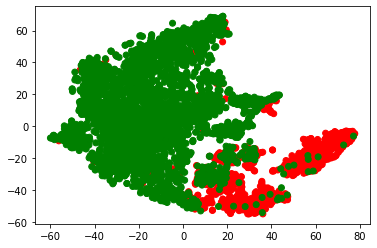

In [947]:
colors = np.array(['red', 'green', 'blue', 'yellow', 'black', 'pink',
                   'orange', 'purple', 'aqua', 'teal', 'lime', 'grey', 'brown'])

colors_idx = np.zeros(len(cells_embedded))
for idx, frg in enumerate(fragments):
    lf = frg[0]
    ri = frg[1]
    colors_idx[lf:ri] = int(idx) #int(idx * (10/len(fragments)))
for idx, frg in enumerate(fragments):
    print(f'fragment {idx} color: {colors[idx]}')
plt.scatter(cells_embedded[:,0], cells_embedded[:,1], c=colors[colors_idx.astype(int)])

## Option 1: select threshold for X or Y

Number of immune cells 2663
Number of cells that will be removed 238
RED if will be taken


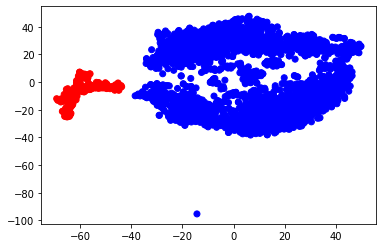

In [912]:
X_val = -40
# Y_val = -40

boolean_indices = cells_embedded[:, 0]<X_val
# boolean_indices = cells_embedded[:, 1]<Y_val

bbb_colors = ['red' if ii else 'blue' for ii in boolean_indices]
cluster_barcodes  = [reference_barcodes[i] for i in range(len(colors_idx)) if (boolean_indices)[i]]
plt.scatter(cells_embedded[:,0], cells_embedded[:,1], c=np.array(bbb_colors))
print(f'Number of immune cells {len(reference_barcodes)}')
print(f'Number of cells that will be removed {len(cluster_barcodes)}')
print("RED if will be taken")

In [913]:
pickle.dump((cluster_barcodes), open(join(OUTPUT_IMMUNE_PATH, f'{SAMPLE}.pkl'), 'wb'))

## Option 2: Select cluster you want to remove:

In [622]:
interasting_cluster = 1

print(f' number of immune cells {len(reference_barcodes)}')
print(f' number of cells that will be removed {sum(colors_idx == interasting_cluster)}')

cluster_barcodes  = [reference_barcodes[i] for i in range(len(colors_idx)) if (colors_idx == interasting_cluster)[i]]

 number of immune cells 3380
 number of cells that will be removed 150


Save the barcodes of the cells you're interested to remove:

In [ ]:
pickle.dump((cluster_barcodes), open(join(OUTPUT_IMMUNE_PATH, f'{SAMPLE}.pkl'), 'wb'))
# OUTPUT_IMMUNE_PATH

## Option 3: Use gaussian clustering to select cells instead

idx 0 color: red
idx 1 color: green
idx 2 color: blue
idx 3 color: yellow
idx 4 color: black
idx 5 color: pink
idx 6 color: orange
idx 7 color: purple
idx 8 color: aqua
idx 9 color: teal
idx 10 color: lime


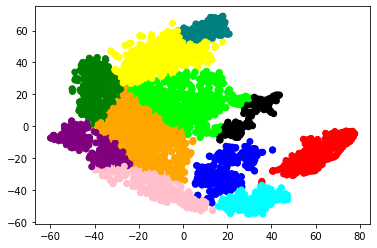

In [959]:
n_clusters = 11


clf_gaussian = GaussianMixture(n_components=n_clusters)
clf_gaussian.fit(cells_embedded)
y_dbscan = clf_gaussian.predict(cells_embedded)


colors = np.array(['red', 'green', 'blue', 'yellow', 'black', 'pink',
                   'orange', 'purple', 'aqua', 'teal', 'lime', 'grey', 'brown'])
for idx in list(set(y_dbscan)):
    print(f'idx {idx} color: {colors[idx]}')

plt.scatter(cells_embedded[:,0], cells_embedded[:,1], c=colors[y_dbscan])

Number of immune cells 3758
Number of cells that will be removed 574
RED if it will be taken


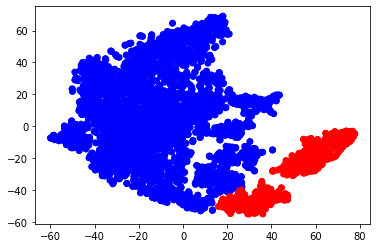

In [962]:
interasting_clusters = [0, 8]
print(f'Number of immune cells {len(reference_barcodes)}')
cluster_barcodes = [reference_barcodes[i] for i in range(len(y_dbscan)) if (y_dbscan[i] in interasting_clusters)]
print(f'Number of cells that will be removed {len(cluster_barcodes)}')
plt.scatter(cells_embedded[:,0], cells_embedded[:,1], 
            c=np.array(['red'  if (y_dbscan[i] in interasting_clusters) else 'blue' for i in range(len(y_dbscan))]))
print("RED if it will be taken")

Save the barcodes of the cells you're interested to remove (NO CHANGE NEDD TO BE DONE):

In [964]:
pickle.dump((cluster_barcodes), open(join(OUTPUT_IMMUNE_PATH, f'{SAMPLE}.pkl'), 'wb'))
# OUTPUT_IMMUNE_PATH

## Option 4: Take the overlap of Gaussian clustering and specific fragments

 number of immune cells 1023
 number of cells that will be removed 141


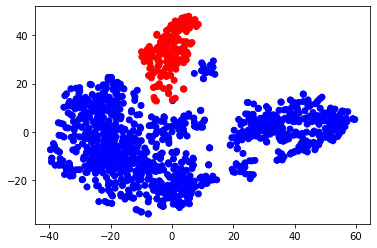

In [766]:
interesting_gaussian_clusters = [2]
interesting_fragments = [1]

overlap_bool_indices = [(y_dbscan[i] in interesting_gaussian_clusters and int(colors_idx[i]) in interesting_fragments) for i in range(len(y_dbscan))]

overlap_colors = np.array(['red' if overlap_bool_indices[ii] else 'blue' for ii in range(len(y_dbscan))])

cluster_barcodes = [reference_barcodes[ii]  for ii in range(len(y_dbscan)) if overlap_bool_indices[ii]]


plt.scatter(cells_embedded[:,0], cells_embedded[:,1], c=overlap_colors)

print(f' number of immune cells {len(reference_barcodes)}')
print(f' number of cells that will be removed {len(cluster_barcodes)}')

Save the barcodes of the cells you're interested to remove (NO CHANGE NEDD TO BE DONE):

In [767]:
pickle.dump((cluster_barcodes), open(join(OUTPUT_IMMUNE_PATH, f'{SAMPLE}.pkl'), 'wb'))

### DEBUG

In [60]:
# DEBUG CHECK COLORS
colors = np.zeros(len(cells_embedded))
for idx, frg in enumerate(fragments):
    lf = frg[0]
    ri = frg[1]
    colors[lf:ri] = int(idx * (10/len(fragments)))

#colors[:3300]= 1
#plt.scatter(cells_embedded[:,0], cells_embedded[:,1], c=colors)

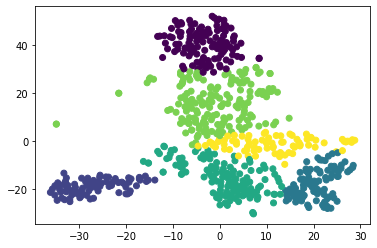

In [64]:
# DEBUG CLUSTERS

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# KMEANS
y_dbscan = KMeans(n_clusters=3, random_state=0).fit(filterd_variance_cells.counts).labels_

# DBSCAN
# clf_dbscan = DBSCAN(eps = 20, min_samples = 10, n_jobs = -1)
# y_dbscan = clf_dbscan.fit_predict(cells_embedded)

# gaussian
clf_gaussian = GaussianMixture(n_components=6)
clf_gaussian.fit(cells_embedded)
y_dbscan = clf_gaussian.predict(cells_embedded)
plt.scatter(cells_embedded[:,0], cells_embedded[:,1], c=y_dbscan)

# First Idea - wasn't used at the end.
## Specific chromosome analysis 

Sample:                         M109
Chromosome 1 has been selected
Num of genes (in chromosome 1): 671
Num of cells:                   5711


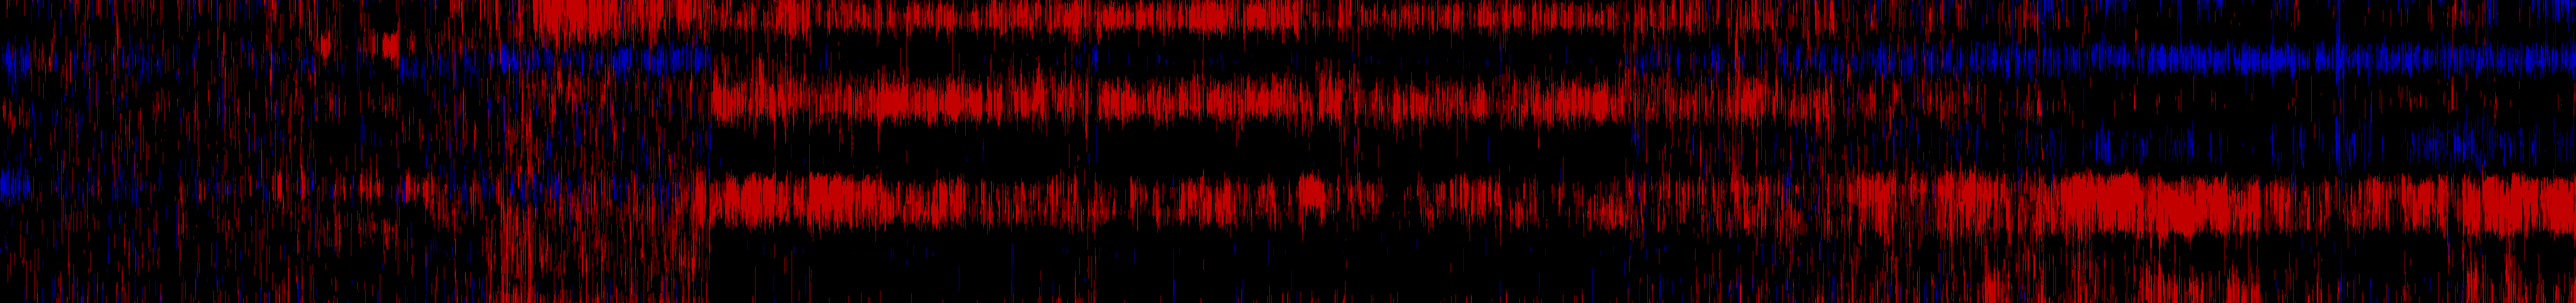

In [230]:
chro = 1

chro_indices = retrieve_genes_indices_by_chro(chro)
chro_genes_vals = genes_vals[chro_indices, :]#.sum(axis=0)
chro_genes_vals = (chro_genes_vals-1)

print(f'Sample:                         {SAMPLE}')
print(f'Chromosome {chro} has been selected')
print(f'Num of genes (in chromosome {chro}): {chro_genes_vals.shape[0]}')
print(f'Num of cells:                   {chro_genes_vals.shape[1]}')

draw(chro_genes_vals)

In [789]:
# clf_dbscan = DBSCAN(eps = 2, min_samples = 10)
# y_dbscan = clf_dbscan.fit_predict(ones_conversion(chro_genes_vals.T))
y_dbscan = KMeans(n_clusters=7, random_state=0).fit(chro_genes_vals.T).labels_
Counter(y_dbscan)

Counter({5: 212, 2: 382, 3: 622, 0: 633, 4: 237, 6: 258, 1: 123})

prints all clusters

In [ ]:
n_genes = chro_genes_vals.shape[0]
n_cells = chro_genes_vals.shape[1]
print(f'n_cells {n_cells}')
print(f'n_genes {n_genes}')
display(draw(chro_genes_vals))
for cls in list(dict(Counter(y_dbscan)).keys()):
    print(f'class: {cls}, n_cells: {sum(y_dbscan==cls)}, {round(sum(y_dbscan==cls)*100/n_cells, 2)}% of the cells')
    is_a_cnv_group(chro_genes_vals.T[y_dbscan==cls])
    display(draw(chro_genes_vals.T[y_dbscan==cls].T))
# display(draw(chro_genes_vals.T[y_dbscan==-1].T))

# DEBUG 

In [ ]:
# display(draw(chro_genes_vals.T[y_dbscan==14].T))

In [ ]:

portions = []
for chro in range(1, 23):
    print(f'Chrom num {chro}', end=' ')
    chro_indices = retrieve_genes_indices_by_chro(chro)
    chro_genes_vals = genes_vals[chro_indices, :]#.sum(axis=0)
    chro_genes_vals = (chro_genes_vals-1)

    n_gene = len(chro_indices)
    n_cells = chro_genes_vals.shape[1]
#     print(f'num of genes in chro {chro}: {n_gene}')
#     print(f'num of cells: {n_cells}')
    portion = np.sum(chro_genes_vals<-0.02)/(n_cells*n_gene)
    portions.append(portion)
    print(portion)
    
np.argsort(np.array(portions))+1
#     # insertion
#     insertion_cells = copy.deepcopy(normalized_chro_genes_vals)
#     insertion_cells[insertion_cells<0] = 0
#     #insertion_cells = np.exp(insertion_cells)
#     insertion_chro_sum = insertion_cells.sum(axis=0)

#     deletion_cells = copy.deepcopy(normalized_chro_genes_vals)
#     deletion_cells[deletion_cells>0] = 0
#     #deletion_cells = np.exp(-deletion_cells)
#     deletion_chro_sum = deletion_cells.sum(axis=0)

In [ ]:

cluster = chro_genes_vals.T[y_dbscan==1]
is_a_cnv_group(cluster)

In [207]:
chro_genes_vals.shape
# np.sum(chro_genes_vals[150, :])
np.sum(chro_genes_vals, axis=1).shape

(226,)

In [ ]:
a = chro_genes_vals.T[y_dbscan==-1][0]
b = chro_genes_vals.T[y_dbscan==-1][2]


np.linalg.norm(a-b)

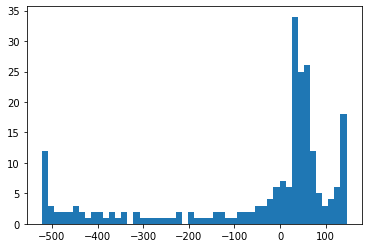

In [208]:
plt.hist(np.sum(chro_genes_vals, axis=1), bins=50)
plt.show()

In [209]:
ddd.shape

(5685, 156)

In [210]:
ddd = copy.deepcopy(deletions)
ddd[ddd!=195] = 0
ddd[ddd==195] = 1
ddd.sum(axis=1)

array([  76.,   77.,   82.,   84.,   87.,   91.,   95.,  101.,  108.,
        118.,  139.,  153.,  178.,  202.,  237.,  268.,  306.,  350.,
        391.,  444.,  506.,  595.,  679.,  758.,  877., 1005., 1136.,
       1285., 1444., 1592., 1761., 1940., 2109., 2286., 2489., 2642.,
       2795., 2929., 3030., 3127., 3226., 3308., 3369., 3435., 3518.,
       3584., 3658., 3730., 3803., 3859., 3928., 3956., 3974., 3977.,
       3984., 3986., 3981., 3968., 3964., 3947., 3930., 3902., 3874.,
       3829., 3791., 3717., 3645., 3545., 3446., 3331., 3199., 3040.,
       2881., 2701., 2521., 2317., 2104., 1921., 1724., 1550., 1371.,
       1210., 1058.,  907.,  778.,  652.,  533.,  456.,  397.,  345.,
        297.,  261.,  232.,  202.,  180.,  158.,  137.,  124.,  108.,
         85.,   78.,   69.,   61.,   55.,   50.,   41.,   36.,   34.,
         29.,   27.,   27.,   26.,   26.,   26.,   25.,   25.,   24.,
         23.,   22.,   21.,   21.,   18.,   18.,   17.,   17.,   17.,
         17.,   16.,

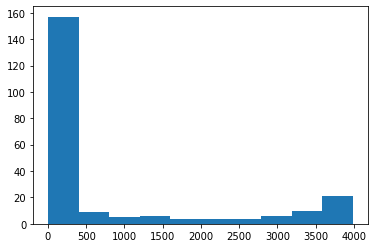

In [211]:
plt.hist(ddd.sum(axis=1))
plt.show()

In [212]:
from sklearn.manifold import TSNE
# ddd = np.concatenate([ddd.T, np.zeros((ddd.shape[0], ddd.shape[0]))])
kmeans = KMeans(n_clusters=4, random_state=0).fit(ddd)
cells_embedded = TSNE(n_components=2, random_state=21).fit_transform(ddd)

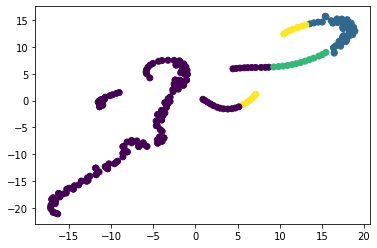

In [213]:
kmeans.labels_
colors = dict(zip(list(range(6))+[-1], [0.1, 0.2, 0.3, 0.4 ,0.5, 0.7, 0.9]))

plt.scatter(cells_embedded[:,0],cells_embedded[:,1], c = list(map(lambda x: colors[x], kmeans.labels_)))
plt.show()


In [215]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# clf_dbscan = DBSCAN(eps = 0.2, min_samples = 10, n_jobs = -1)
# y_dbscan = clf_dbscan.fit_predict(ddd.T)

# clf_gaussian = GaussianMixture(n_components=3)
# clf_gaussian.fit(ddd.T)
# y_gaussian = clf_gaussian.predict(ddd.T)

# plt.scatter(cells_embedded[:,0],cells_embedded[:,1], c = list(map(lambda x: colors[x], y_gaussian)))
# plt.show()

In [216]:

sum(kmeans.labels_==1)

35

In [217]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(ddd)
embedding.shape

(226, 2)

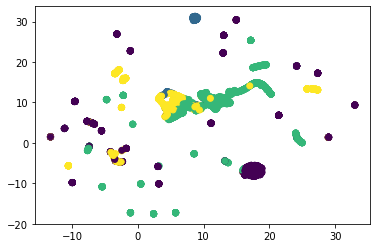

In [129]:
colors = dict(zip(list(range(6))+[-1], [0.1, 0.2, 0.3, 0.4 ,0.5, 0.7, 0.9]))


# clf_dbscan = DBSCAN(eps = 0.2, min_samples = 10, n_jobs = -1)
# y_dbscan = clf_dbscan.fit_predict(ddd.T)

clf_gaussian = GaussianMixture(n_components=4)
clf_gaussian.fit(ddd)
y_gaussian = clf_gaussian.predict(ddd)


plt.scatter(embedding[:, 0],embedding[:, 1], c = list(map(lambda x: colors[x], y_gaussian)))
plt.show()


In [135]:
sum(y_gaussian==1)

310

In [137]:
clf_dbscan = DBSCAN(eps = 0.2, min_samples = 10, n_jobs = -1)
y_dbscan = clf_dbscan.fit_predict(ddd)

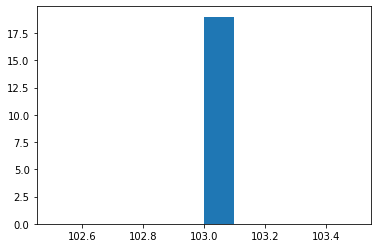

In [192]:
from collections import Counter
Counter(y_dbscan)
# y_dbscan[-156:]


plt.hist(np.sum(ddd[y_dbscan==19], axis=1))
plt.show()

In [194]:
np.where(kmeans.labels_==1)

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
          33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
          44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
          55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
          66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
          77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
          88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
          99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
         110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
         121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
         132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
         143,  144,  145,  146,  147, 

In [749]:
p = r'D:\Technion studies\Keren Laboratory\Data\droplet_seq\all_samples_10.12.20\M112\M112.pkl'
import pickle
file = pickle.load(open(p, 'rb'))


In [759]:
file.cells_information[0].is_cancer

False

In [218]:
kkk = ddd[kmeans.labels_==1]
rgbArray = np.zeros((n_gene, kkk.shape[0], 3), 'uint8')
rgbArray[..., 0] = 0
rgbArray[..., 1] = 0 #chro_genes_vals*256
rgbArray[..., 2] = kkk.T*195 #chro_genes_vals*256
img = Image.fromarray(rgbArray)
img

ValueError: could not broadcast input array from shape (5529,35) into shape (226,35)

Creating a dictionary containing all invercnv.png of all samples:

In [496]:
from shutil import copyfile


DIR_PATH = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\executions\all_data_31.12.20'
OUT = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\temporal garbage\ddd'
for file, dst in [(join(DIR_PATH, folder, 'infercnv.png'), join(OUT, f'{folder}_infercnv.png')) for folder in os.listdir(DIR_PATH)]:
    if os.path.isfile(file):
        copyfile(file, dst)
